# Project 3 - Instacart Classification

**The goal of this project was to investigate whether or not I could create a model to make predictions about future orders, potentially using the model to target promotions towards a specific group to increase sales.  I also wanted to investigate whether the cart makeup of an order is different for those who purchase frequently vs those who purchase infrequently**

In [1]:
import numpy as np
import pandas as pd
from psycopg2 import connect
import pandas.io.sql as pd_sql
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Getting Usable Data

## Download Merged Dataset from AWS PostgreSQL into DataFrame

In [2]:
connection_args = {
    'host': '52.14.29.50',
    'user': 'ubuntu',
    'port': 5432
}

In [3]:
connection = connect(**connection_args, dbname='instacart')
cursor = connection.cursor()
cursor.execute("SELECT * FROM everything_subset;")
df = pd.DataFrame(cursor.fetchall())

## Rename Columns and Fill in Missing Values

In [4]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,37964,4,16,31717,1328274,prior,14,0,13,3.0,3,0,Organic Cilantro,fresh herbs,produce


In [5]:
df.shape

(784959, 15)

In [6]:
df.columns = ['user_id','department_id','aisle_id','product_id','order_id','eval_set',\
              'order_number','order_dow','order_hour_of_day','days_since_prior_order',\
              'add_to_cart_order','reordered','product_name','aisle','department']

In [7]:
df.head(1)

,user_id,department_id,aisle_id,product_id,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,aisle,department
0,37964,4,16,31717,1328274,prior,14,0,13,3.0,3,0,Organic Cilantro,fresh herbs,produce


In [8]:
df = df.sort_values(by=['user_id','order_number']).reset_index().drop('index',axis=1)

df = df.drop('eval_set', axis=1)

In [9]:
df.days_since_prior_order = df.days_since_prior_order.fillna(value=pd.np.nan).astype(float)

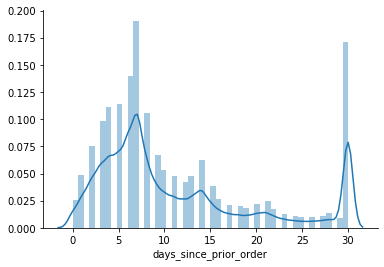

In [10]:
sns.distplot(df.days_since_prior_order.dropna())
sns.despine()

In [11]:
df.days_since_prior_order.max()

30.0

In [12]:
df[df['days_since_prior_order'] >= 7].shape

(464348, 14)

In [13]:
# Grouped data so that each row represents a single order that a customer made
df_by_order = df.groupby(['user_id','order_number','order_id'],
                        as_index = False)['order_dow','order_hour_of_day','days_since_prior_order'].first()
df_by_order.head(2)

,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order
0,35,1,1269089,5,21,NaN
1,35,2,2562704,3,16,26.0


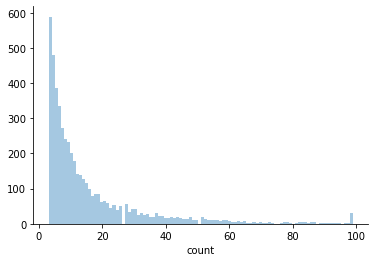

In [14]:
sns.distplot(df_by_order.groupby(['user_id']).agg(['count'])['order_number']['count'], kde=False, bins=100)
sns.despine()

I realized here that the dataset lumps all values above 30 for 'days since prior order' into 30.
In addition I was surprised by how frequently customers in this dataset made orders, and upon further investigation found that the datset isn't a representation of the entire population, but rather a subset of more 'regular' customers who made between 3 and 99 total orders over this time frame

## Create Independent Variable (Re-order within 7 days)

In [15]:
df_by_order['days_until_next_order'] = \
    df_by_order.groupby('user_id')['days_since_prior_order'].transform(lambda x: x.shift(-1))
df_by_order.head(3)

,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order,days_until_next_order
0,35,1,1269089,5,21,NaN,26.0
1,35,2,2562704,3,16,26.0,30.0
2,35,3,1136841,6,9,30.0,22.0


In [16]:
def reorder_7(x):
    if x <= 7:
        return 1
    else:
        return 0

In [17]:
df_by_order_dropna = df_by_order.dropna()

df_by_order_dropna['reordered_within_7_days'] = df_by_order_dropna['days_until_next_order'].apply(lambda x: reorder_7(x))

df_by_order_dropna = df_by_order_dropna.drop('days_until_next_order', axis=1)

/home/rob/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
df_by_order_dropna.head(3)

,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order,reordered_within_7_days
1,35,2,2562704,3,16,26.0,0
2,35,3,1136841,6,9,30.0,0
3,35,4,457048,0,20,22.0,0


# Feature Engineering Part 1

## Create Feature for Average Days Between All Previous Orders

In [19]:
df_by_order_dropna['cum_sum'] = df_by_order_dropna.groupby(['user_id'])['days_since_prior_order'].cumsum()

df_by_order_dropna['total_orders'] = df_by_order_dropna['order_number']-1

df_by_order_dropna['cum_average_days_since'] = df_by_order_dropna.cum_sum / df_by_order_dropna.total_orders

In [20]:
df_by_order_dropna.head(2)

,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order,reordered_within_7_days,cum_sum,total_orders,cum_average_days_since
1,35,2,2562704,3,16,26.0,0,26.0,1,26.0
2,35,3,1136841,6,9,30.0,0,56.0,2,28.0


In [21]:
df_by_order_dropna = df_by_order_dropna.drop(['cum_sum','total_orders'],axis=1)

In [22]:
df_by_order_dropna.head(2)

,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order,reordered_within_7_days,cum_average_days_since
1,35,2,2562704,3,16,26.0,0,26.0
2,35,3,1136841,6,9,30.0,0,28.0


In [23]:
cols = df_by_order_dropna.columns.tolist()

cols = [cols[6]]+cols[:-2]+[cols[-1]]

In [24]:
cols

['reordered_within_7_days',
 'user_id',
 'order_number',
 'order_id',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order',
 'cum_average_days_since']

In [25]:
df_by_order_dropna = df_by_order_dropna[cols]

In [26]:
df_by_order_dropna.head(2)

,reordered_within_7_days,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order,cum_average_days_since
1,0,35,2,2562704,3,16,26.0,26.0
2,0,35,3,1136841,6,9,30.0,28.0


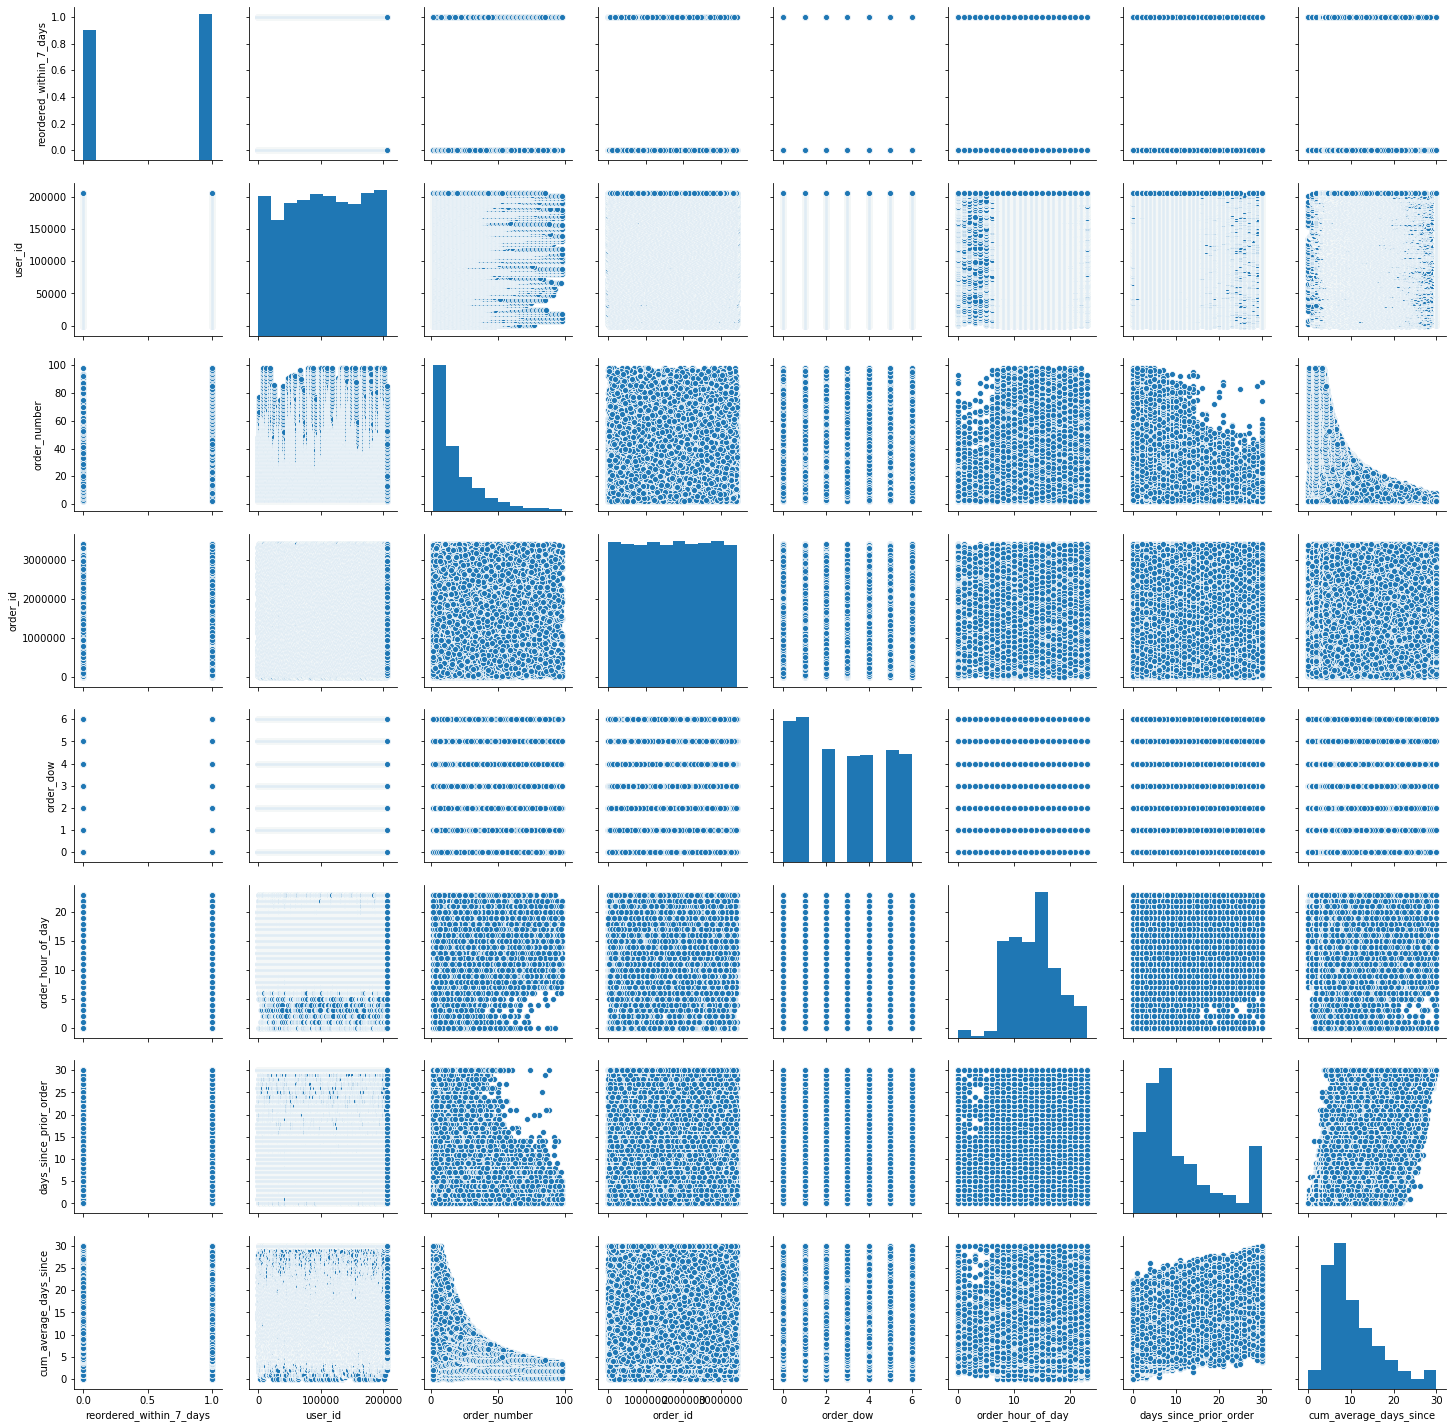

In [27]:
sns.pairplot(df_by_order_dropna)

## Create Feature for Total Number of Products in Each Order

In [28]:
df_product_list = df.groupby(['order_id'])['product_id'].apply(list).reset_index()

order_products = df_product_list.set_index('order_id').product_id.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(int).reset_index()

In [29]:
order_products.head(3)

,order_id,0
0,14,20392
1,14,27845
2,14,8575


In [30]:
df_master = df_by_order_dropna.merge(df_product_list, on='order_id', how='left').rename(columns={'product_id':'product_ids'})

In [31]:
df_master.head(2)

,reordered_within_7_days,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order,cum_average_days_since,product_ids
0,0,35,2,2562704,3,16,26.0,26.0,"[45084, 28842, 48230, 2846, 45066, 33043, 1446..."
1,0,35,3,1136841,6,9,30.0,28.0,"[4942, 19677, 47280, 21137, 39275, 34969, 7969..."


In [32]:
df_master['num_products_in_order'] = df_master.product_ids.apply(lambda x: len(x))

# Initial Modeling

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix

In [34]:
# Split data so that orders from the same users don't spill over into test set, by splitting users first
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_te = df_tr['reordered_within_7_days'], df_te['reordered_within_7_days']
    X_tr = df_tr.drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1) 
    X_te = df_te.drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1)

    return X_tr, X_te, y_tr, y_te

In [35]:
X, X_test, y, y_test = get_user_split_data(df_master)

In [36]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X, y)
lr.score(X_test, y_test)

0.7249743764947045

In [37]:
lr.coef_

array([[ 0.02548013, -0.02449023, -0.02181801, -0.02576725, -0.11361284,
        -0.00568573]])

In [38]:
confusion_matrix(y_test, lr.predict(X_test))

array([[4122, 2434],
       [1591, 6488]])

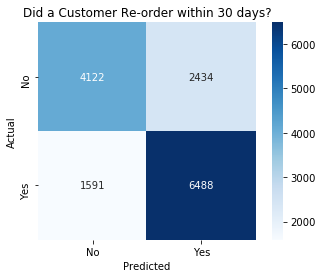

In [39]:
lr_confusion = confusion_matrix(y_test, lr.predict(X_test))
sns.heatmap(lr_confusion, cmap=plt.cm.Blues, annot=True, fmt='g', square=True,
           xticklabels=['No','Yes'],
           yticklabels=['No','Yes'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Did a Customer Re-order within 30 days?');

In [40]:
from ipywidgets import interactive, FloatSlider

In [41]:
def make_confusion_matrix(model, threshold=0.5):
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['No','Yes'],
           yticklabels=['No','Yes']);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [42]:
interactive(lambda threshold: make_confusion_matrix(lr, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

# Feature Engineering Part 2

## Get Product, Aisle, and Department Info

In [43]:
connection = connect(**connection_args, dbname='instacart')
cursor = connection.cursor()
cursor.execute("SELECT * FROM products;")
df_products = pd.DataFrame(cursor.fetchall())

In [44]:
df_products.columns = ['product_id','product_name','aisle_id','department_id']

In [45]:
df_products.head(2)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13


## Identify Which Products Belong to Certain Categories of Interest

In [46]:
def is_organic(x):
    if 'Organic' in x:
        return 1
    else:
        return 0

df_products['is_organic'] = df_products.product_name.apply(lambda x: is_organic(x))

def is_produce(x):
    if x == 4:
        return 1
    else:
        return 0

df_products['is_produce'] = df_products.department_id.apply(lambda x: is_produce(x))

def is_alcohol(x):
    if x == 5:
        return 1
    else:
        return 0

df_products['is_alcohol'] = df_products.department_id.apply(lambda x: is_alcohol(x))

def is_frozen(x):
    if x == 1:
        return 1
    else:
        return 0

df_products['is_frozen'] = df_products.department_id.apply(lambda x: is_frozen(x))

def is_meat_seafood(x):
    if x == 12:
        return 1
    else:
        return 0
    
df_products['is_meat_seafood'] = df_products.department_id.apply(lambda x: is_meat_seafood(x))

def is_breakfast(x):
    if x == 14:
        return 1
    else:
        return 0
    
df_products['is_breakfast'] = df_products.department_id.apply(lambda x: is_breakfast(x))

def is_dairy(x):
    if x == 16:
        return 1
    else:
        return 0
    
df_products['is_dairy'] = df_products.department_id.apply(lambda x: is_dairy(x))

def is_deli(x):
    if x == 20:
        return 1
    else:
        return 0
    
df_products['is_deli'] = df_products.department_id.apply(lambda x: is_deli(x))

def is_bakery(x):
    if x == 3:
        return 1
    else:
        return 0
    
df_products['is_bakery'] = df_products.department_id.apply(lambda x: is_bakery(x))

def is_beverages(x):
    if x == 7:
        return 1
    else:
        return 0
    
df_products['is_beverages'] = df_products.department_id.apply(lambda x: is_beverages(x))

In [47]:
df_products.head(3)

,product_id,product_name,aisle_id,department_id,is_organic,is_produce,is_alcohol,is_frozen,is_meat_seafood,is_breakfast,is_dairy,is_deli,is_bakery,is_beverages
0,1,Chocolate Sandwich Cookies,61,19,0,0,0,0,0,0,0,0,0,0
1,2,All-Seasons Salt,104,13,0,0,0,0,0,0,0,0,0,0
2,3,Robust Golden Unsweetened Oolong Tea,94,7,0,0,0,0,0,0,0,0,0,1


# Combine Product Level Information to Main DataFrame

In [48]:
df_exploded = order_products.merge(df_master, on='order_id', how='left')

df_exploded = df_exploded.sort_values(by=['user_id','order_number']).reset_index().drop('index',axis=1).rename(columns={0:'product_id'})

In [49]:
df_exploded.head(2)

,order_id,product_id,reordered_within_7_days,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,cum_average_days_since,product_ids,num_products_in_order
0,2562704,45084,0.0,35.0,2.0,3.0,16.0,26.0,26.0,"[45084, 28842, 48230, 2846, 45066, 33043, 1446...",20.0
1,2562704,28842,0.0,35.0,2.0,3.0,16.0,26.0,26.0,"[45084, 28842, 48230, 2846, 45066, 33043, 1446...",20.0


In [50]:
df_exploded = df_exploded.merge(df_products, on='product_id', how='left')

In [51]:
# Taking the mean of each column tells us Percentage of each category that is in a particular order
cart_breakdown = df_exploded.groupby(['user_id','order_number','order_id'])\
    ['is_organic','is_produce','is_alcohol','is_frozen','is_meat_seafood',
     'is_breakfast','is_dairy','is_deli','is_bakery','is_beverages'].mean().reset_index()

In [52]:
cart_breakdown.head(2)

,user_id,order_number,order_id,is_organic,is_produce,is_alcohol,is_frozen,is_meat_seafood,is_breakfast,is_dairy,is_deli,is_bakery,is_beverages
0,35.0,2.0,2562704,0.150000,0.5,0.0,0.050000,0.0,0.000000,0.150000,0.0,0.100000,0.050000
1,35.0,3.0,1136841,0.222222,0.5,0.0,0.055556,0.0,0.111111,0.166667,0.0,0.055556,0.055556


In [53]:
cart_breakdown[['user_id','order_number']] = cart_breakdown[['user_id','order_number']].astype(int)

In [54]:
df_master = df_master.merge(cart_breakdown[['order_id','is_organic','is_produce','is_alcohol',
                                            'is_frozen','is_meat_seafood','is_breakfast','is_dairy','is_deli',
                                            'is_bakery','is_beverages']], on='order_id', how='left')

In [55]:
df_master.head(1)

,reordered_within_7_days,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order,cum_average_days_since,product_ids,num_products_in_order,is_organic,is_produce,is_alcohol,is_frozen,is_meat_seafood,is_breakfast,is_dairy,is_deli,is_bakery,is_beverages
0,0,35,2,2562704,3,16,26.0,26.0,"[45084, 28842, 48230, 2846, 45066, 33043, 1446...",20,0.15,0.5,0.0,0.05,0.0,0.0,0.15,0.0,0.1,0.05


# Testing Different Models

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve

## Logistic Regression

In [57]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_te = df_tr['reordered_within_7_days'], df_te['reordered_within_7_days']
    X_tr = df_tr.drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1) 
    X_te = df_te.drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1)

    return X_tr, X_te, y_tr, y_te

In [58]:
X, X_test, y, y_test = get_user_split_data(df_master)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X, y)
lr.score(X_test, y_test)

/home/rob/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.7247693884523403

In [59]:
lr.coef_

array([[ 0.02493644, -0.02317063, -0.02230036, -0.02543242, -0.11366466,
        -0.00741969,  0.28594155,  0.10022502, -0.00033656, -0.13216683,
        -0.05190699,  0.0497082 ,  0.03168352,  0.21522079,  0.1060948 ,
        -0.05033439]])

In [60]:
y_predict = lr.predict(X_test)
f1_score(y_test, y_predict)

0.7628076787186432

In [61]:
confusion_matrix(y_test, lr.predict(X_test))

array([[4130, 2426],
       [1602, 6477]])

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

ROC AUC score =  0.7920069514882814


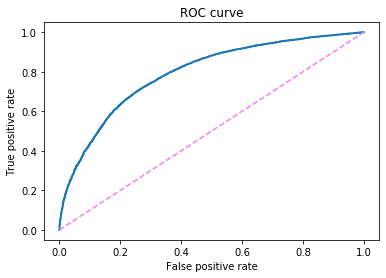

In [63]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

## Random Forest

In [64]:
tree = RandomForestClassifier()

tree.fit(X,y)
tree.score(X_test, y_test)

/home/rob/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6924496071062521

In [65]:
tree.feature_importances_

array([0.10978143, 0.04769166, 0.06893866, 0.11096009, 0.23099535,
       0.06370435, 0.06193405, 0.06426853, 0.00459438, 0.03647155,
       0.02226399, 0.01950626, 0.05852129, 0.02582162, 0.02975848,
       0.0447883 ])

In [66]:
y_predict = tree.predict(X_test)
f1_score(y_test, y_predict)

0.7087296964990616

In [67]:
confusion_matrix(y_test, tree.predict(X_test))

array([[4658, 1898],
       [2603, 5476]])

ROC AUC score =  0.7557041108166074


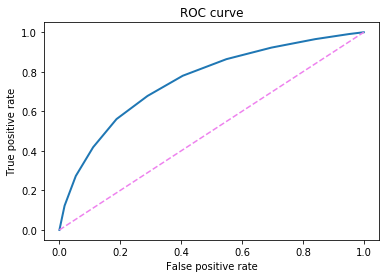

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, tree.predict_proba(X_test)[:,1]))

## Naive Bayes

In [69]:
from sklearn.naive_bayes import GaussianNB

In [70]:
# Compare to Logistic Regression 
lr = LogisticRegression(solver='lbfgs')
lr.fit(X, y)
print("Accuracy = ", lr.score(X_test, y_test))

y_predict = lr.predict(X_test)
print("F1 Score = ", f1_score(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
print("ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

print(confusion_matrix(y_test, lr.predict(X_test)))

Accuracy =  0.7247693884523403
F1 Score =  0.7628076787186432
ROC AUC score =  0.7920069514882814
[[4130 2426]
 [1602 6477]]


/home/rob/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [71]:
nb = GaussianNB()
nb.fit(X, y)

print("Accuracy = ", nb.score(X_test, y_test))

y_predict = nb.predict(X_test)
print("F1 Score = ", f1_score(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:,1])
print("ROC AUC score = ", roc_auc_score(y_test, nb.predict_proba(X_test)[:,1]))

print(confusion_matrix(y_test, nb.predict(X_test)))

Accuracy =  0.70700375811411
F1 Score =  0.7501165501165501
ROC AUC score =  0.7669960406996771
[[3911 2645]
 [1643 6436]]


## K-Nearest Neighbors

In [72]:
from sklearn.neighbors import KNeighborsClassifier

In [73]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X, y)

print("Accuracy = ", knn.score(X_test, y_test))

y_predict = knn.predict(X_test)
print("F1 Score = ", f1_score(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
print("ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))

print(confusion_matrix(y_test, knn.predict(X_test)))

Accuracy =  0.7014690809702767
F1 Score =  0.7298918083462131
ROC AUC score =  0.7589196310442918
[[4363 2193]
 [2176 5903]]


***
Attempted to run Support Vector Machine models as well, but dataset was too large for models to handle.

After some Initial Testing, it seems that Logistic Regression produced the best results.
As for features, the most important feature appeared to be Average Days Between Past Orders;
the created features pertaining to cart breakdowns did not appear to improve the model
***

In [ ]:
# df_master.to_pickle("master.pickle")

# Cross Validation Testing

In [77]:
with open('master.pickle', 'rb') as file:
    df = pickle.load(file)

In [78]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [79]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_te = df_tr['reordered_within_7_days'], df_te['reordered_within_7_days']
    X_tr = df_tr.drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1) 
    X_te = df_te.drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1)

    return X_tr, X_te, y_tr, y_te

In [80]:
X, X_test, y, y_test = get_user_split_data(df)

In [81]:
rs = np.random.RandomState(42)

total_users = df['user_id'].unique() 
test_users = rs.choice(total_users, 
                       size=int(total_users.shape[0] * 0.2), 
                       replace=False)

df_tr = df[~df['user_id'].isin(test_users)]
df_te = df[df['user_id'].isin(test_users)] 

y_tr, y_te = df_tr['reordered_within_7_days'], df_te['reordered_within_7_days']
X_tr = df_tr.drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1) 
X_te = df_te.drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1)

X, X_test, y, y_test = X_tr, X_te, y_tr, y_te

In [82]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1)

cv_lr_score, cv_RC_score= [], [] 
lr_train, RC_train = [], []
lr_roc, RC_roc = [], []
lr_roc_train, RC_roc_train = [], []

cv_users = df_tr['user_id'].unique()

for tr_user, val_user in kf.split(cv_users):
    
    X_train = df_tr[df_tr['user_id'].isin(tr_user)].drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1) 
    y_train = df_tr[df_tr['user_id'].isin(tr_user)]['reordered_within_7_days']

    X_val = df_tr[df_tr['user_id'].isin(val_user)].drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1) 
    y_val = df_tr[df_tr['user_id'].isin(val_user)]['reordered_within_7_days']

    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    cv_lr_score.append(f1_score(y_val, lr.predict(X_val)))
    lr_train.append(f1_score(y_train, lr.predict(X_train)))
    lr_roc.append(roc_auc_score(y_val, lr.predict_proba(X_val)[:,1]))
    lr_roc_train.append(roc_auc_score(y_train, lr.predict_proba(X_train)[:,1]))

    
    RC = RandomForestClassifier(n_estimators=300, max_features=2)
    RC.fit(X_train, y_train)
    cv_RC_score.append(f1_score(y_val, RC.predict(X_val)))
    RC_train.append(f1_score(y_train, RC.predict(X_train)))
    RC_roc.append(roc_auc_score(y_val, RC.predict_proba(X_val)[:,1]))
    RC_roc_train.append(roc_auc_score(y_train, RC.predict_proba(X_train)[:,1]))

print(f'Logistic Regression train : {np.mean(lr_train):.3f} +- {np.std(lr_train):.3f}')
print(f'Logistic Regression cv : {np.mean(cv_lr_score):.3f} +- {np.std(cv_lr_score):.3f}')
print(f'Logistic Regression ROC train: {np.mean(lr_roc_train):.3f} +- {np.std(lr_roc_train):.3f}')
print(f'Logistic Regression ROC cv: {np.mean(lr_roc):.3f} +- {np.std(lr_roc):.3f}')
print(confusion_matrix(y_val, lr.predict(X_val)))

print(f'Random Forest mean train : {np.mean(RC_train):.3f} +- {np.std(RC_train):.3f}')
print(f'Random Forest mean cv : {np.mean(cv_RC_score):.3f} +- {np.std(cv_RC_score):.3f}')
print(f'Random Forest ROC train: {np.mean(RC_roc_train):.3f} +- {np.std(RC_roc_train):.3f}')
print(f'Random Forest ROC cv: {np.mean(RC_roc):.3f} +- {np.std(RC_roc):.3f}')
print(confusion_matrix(y_val, RC.predict(X_val)))
                   

/home/rob/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/rob/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/rob/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/rob/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/rob/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs faile

Logistic Regression train : 0.706 +- 0.017
Logistic Regression cv : 0.635 +- 0.100
Logistic Regression ROC train: 0.802 +- 0.007
Logistic Regression ROC cv: 0.762 +- 0.041
[[70 31]
 [16 66]]
Random Forest mean train : 1.000 +- 0.000
Random Forest mean cv : 0.606 +- 0.086
Random Forest ROC train: 1.000 +- 0.000
Random Forest ROC cv: 0.718 +- 0.024
[[73 28]
 [28 54]]


In [83]:
list(zip(X.columns, RC.feature_importances_))

[('order_number', 0.11156468971941426),
 ('order_dow', 0.04729276944512484),
 ('order_hour_of_day', 0.07997347606503659),
 ('days_since_prior_order', 0.11966353073399992),
 ('cum_average_days_since', 0.15576080344345786),
 ('num_products_in_order', 0.06278717825988298),
 ('is_organic', 0.05916930972561339),
 ('is_produce', 0.06713130271537357),
 ('is_alcohol', 0.0),
 ('is_frozen', 0.03505910333662934),
 ('is_meat_seafood', 0.0227984741034041),
 ('is_breakfast', 0.023361915286376798),
 ('is_dairy', 0.0485516618241813),
 ('is_deli', 0.03702006050003558),
 ('is_bakery', 0.029810223040269816),
 ('is_beverages', 0.035955136977312306),
 ('reordered', 0.06410036482388753)]

In [84]:
#Scaling and Changing C parameter produced worse cv results

kf = KFold(n_splits=5, shuffle=True, random_state = 1)

cv_lr_score = []
lr_train = []
lr_roc = []
lr_roc_train = []


cv_users = df_tr['user_id'].unique()

for tr_user, val_user in kf.split(cv_users):
    
    X_train = df_tr[df_tr['user_id'].isin(tr_user)].drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1) 
    y_train = df_tr[df_tr['user_id'].isin(tr_user)]['reordered_within_7_days']

    X_val = df_tr[df_tr['user_id'].isin(val_user)].drop(['product_ids','user_id','order_id','reordered_within_7_days'],axis=1) 
    y_val = df_tr[df_tr['user_id'].isin(val_user)]['reordered_within_7_days']

    lr = LogisticRegression(solver='lbfgs',C=.1)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lr.fit(X_train_scaled, y_train)
    cv_lr_score.append(f1_score(y_val, lr.predict(X_val_scaled)))
    lr_train.append(f1_score(y_train, lr.predict(X_train_scaled)))
    lr_roc.append(roc_auc_score(y_val, lr.predict_proba(X_val_scaled)[:,1]))
    lr_roc_train.append(roc_auc_score(y_train, lr.predict_proba(X_train_scaled)[:,1]))



print(f'Logistic Regression train : {np.mean(lr_train):.3f} +- {np.std(lr_train):.3f}')
print(f'Logistic Regression cv : {np.mean(cv_lr_score):.3f} +- {np.std(cv_lr_score):.3f}')
print(f'Logistic Regression ROC train: {np.mean(lr_roc_train):.3f} +- {np.std(lr_roc_train):.3f}')
print(f'Logistic Regression ROC cv: {np.mean(lr_roc):.3f} +- {np.std(lr_roc):.3f}')
print(confusion_matrix(y_val, lr.predict(X_val_scaled)))


Logistic Regression train : 0.703 +- 0.014
Logistic Regression cv : 0.623 +- 0.099
Logistic Regression ROC train: 0.803 +- 0.007
Logistic Regression ROC cv: 0.757 +- 0.040
[[71 30]
 [17 65]]


# Fit Model on Entire Dataset, Test, and Results

In [85]:
X, X_test, y, y_test = get_user_split_data(df)

In [86]:
lr_final = LogisticRegression(solver='lbfgs', C=1)

X_all = np.concatenate((X, X_test))
y_all = np.concatenate((y,y_test))

scaler_final = StandardScaler()
X_all_scaled = scaler_final.fit_transform(X_all)
X_test_scaled = scaler_final.transform(X_test)
lr_final.fit(X_all_scaled, y_all)

print(confusion_matrix(y_test, lr_final.predict(X_test_scaled)))

[[4115 2441]
 [1591 6488]]


In [87]:
def make_confusion_matrix(model, threshold=0.5):
    y_predict = (model.predict_proba(X_test_scaled)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=200)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Greens, annot=True, square=True, fmt='g',
           xticklabels=['No','Yes'],
           yticklabels=['No','Yes']);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [88]:
from ipywidgets import interactive, FloatSlider

In [89]:
interactive(lambda threshold: make_confusion_matrix(lr_final, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [90]:
THRESHOLD = .58
preds = np.where(lr_final.predict_proba(X_test_scaled)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   f1_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "f1", "roc_auc_score"])

,0
accuracy,0.720260
recall,0.701077
f1,0.734535
roc_auc_score,0.722488


**We are much more interested in trying to predict customers who won't come back within 7 days,
meaning we care most about predicting True Negatives, and decreasing False Positives.  If we were to target those the model predicted as 'will not be coming back within 7 days', we would be sending needless promotions to the False Negatives, which is 2415/(2415+4877) = 33% of those who will receive a promotion.
Further Cost benifit analysis would be necessary to determine if such a promotion would increase revenue.**

In [91]:
df2 = pd.DataFrame(X_all)
df2['predicted'] = lr_final.predict(X_all_scaled)
df2['actual'] = y_all
df2['dif'] = df2.predicted - df2.actual

def cf(row):
    if row['dif'] == 0 and row['predicted'] == 1:
        val = 'TP'
    elif row['dif'] == 0 and row['predicted'] == 0:
        val = 'TN'
    elif row['dif'] == 1:
        val = 'FP'
    else:
        val = 'FN'
    return val

df2['CF'] = df2.apply(cf, axis=1)
df2.columns = ['order_number','order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'cum_average_days_since', 'num_products_in_order',
       'is_organic', 'is_produce', 'is_alcohol', 'is_frozen',
       'is_meat_seafood', 'is_breakfast', 'is_dairy', 'is_deli', 'is_bakery',
       'is_beverages', 'reordered', 'predicted', 'actual', 'dif', 'CF']

In [92]:
df2.groupby('CF').mean()

,order_number,order_dow,order_hour_of_day,days_since_prior_order,cum_average_days_since,num_products_in_order,is_organic,is_produce,is_alcohol,is_frozen,is_meat_seafood,is_breakfast,is_dairy,is_deli,is_bakery,is_beverages,reordered,predicted,actual,dif
CF,,,,,,,,,,,,,,,,,,,,
FN,8.874409,2.770666,13.807589,15.087773,14.734103,10.736425,0.263023,0.258898,0.008937,0.073460,0.022969,0.023634,0.161870,0.029033,0.035527,0.107090,0.568718,0,1,-1
FP,19.673104,2.746746,13.256277,6.790411,7.346123,9.941137,0.320498,0.285459,0.006885,0.060899,0.021385,0.020602,0.174089,0.029995,0.035835,0.101662,0.655337,1,0,1
TN,7.775883,2.845619,13.836423,17.860232,17.120803,10.656345,0.255867,0.261008,0.007873,0.074016,0.022323,0.023433,0.160417,0.029003,0.036046,0.109506,0.566514,0,0,0
TP,28.733172,2.775946,13.014317,5.287342,5.966827,9.469941,0.341853,0.298985,0.005491,0.056374,0.018930,0.019308,0.176838,0.029780,0.035637,0.098519,0.708484,1,1,0


In [93]:
df2.groupby('actual').mean()

,order_number,order_dow,order_hour_of_day,days_since_prior_order,cum_average_days_since,num_products_in_order,is_organic,is_produce,is_alcohol,is_frozen,is_meat_seafood,is_breakfast,is_dairy,is_deli,is_bakery,is_beverages,reordered,predicted,dif
actual,,,,,,,,,,,,,,,,,,,
0,12.199638,2.808855,13.620707,13.744130,13.486275,10.390408,0.279899,0.270100,0.007506,0.069138,0.021974,0.022381,0.165500,0.029372,0.035968,0.106589,0.599541,0.371831,0.371831
1,24.404122,2.774795,13.187244,7.423757,7.878022,9.746024,0.324669,0.290247,0.006243,0.060098,0.019810,0.020251,0.173575,0.029617,0.035613,0.100387,0.678016,0.782008,-0.217992


In [94]:
list(zip(df2.columns, lr_final.coef_[0]))

[('order_number', 0.4817623637172579),
 ('order_dow', -0.043722642272245406),
 ('order_hour_of_day', -0.09749717700804138),
 ('days_since_prior_order', -0.21967497828830262),
 ('cum_average_days_since', -0.7464584796270536),
 ('num_products_in_order', -0.05960051361740702),
 ('is_organic', 0.07226623263290637),
 ('is_produce', 0.04434853954927506),
 ('is_alcohol', -0.0038236493367493182),
 ('is_frozen', -0.00910389535350009),
 ('is_meat_seafood', -0.013088644449131544),
 ('is_breakfast', -0.0004745634443546229),
 ('is_dairy', 0.01733813789114114),
 ('is_deli', 0.0202800870360042),
 ('is_bakery', 0.005168858728769931),
 ('is_beverages', 0.011907938684018233),
 ('reordered', -0.07728262293194625)]

**Unfortunately I was unable to find any significant differences in cart-makeup percentage between those who did re-purchase within a week and those that did not.  The most impactful feature in that category was percentage of organic products, followed by percentage produce.  It is worth noting that having more alcohol or frozen foods had a negative relationship with chance of re-ordering soon, which could suggest that these categories make up more of the impulse orders.
It would also have been helpful to identify characteristics of the False Positives, as these are customers that the model predicted as likely to come back but did not.  These would great customers to target since they would most likely be 'low-hanging fruit', but I was not able to find any significant differences between them and the True Positives.**

***